Imports
============

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from dvn.dvn_fcn import DeepVesselNetFCN
from dvn.solver import Solver
from dvn.data_utils import SyntheticData

torch.set_default_tensor_type('torch.FloatTensor')
# set up default cuda device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Firstly we load the data
============


In [2]:
patch_size=64

train_synthetic = SyntheticData(root_path="./data/train/", patch_size=patch_size)
val_synthetic = SyntheticData(root_path="./data/val/", patch_size=patch_size)

print("DONE")

DONE


Visualize part of the data
============

In [3]:
print("Train size: %i" % len(train_synthetic))
print("Validation size: %i" % len(val_synthetic))
print("Img size: ", train_synthetic[0][0].size())
print("Segmentation size: ", train_synthetic[0][1].size())

Train size: 110
Validation size: 26
Img size:  torch.Size([1, 64, 64, 64])
Segmentation size:  torch.Size([64, 64, 64])


Design network 
============

In [4]:
train_loader = torch.utils.data.DataLoader(train_synthetic[5:13], batch_size=1, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_synthetic[15:19], batch_size=1, shuffle=False, num_workers=0)

model = DeepVesselNetFCN()
model.to(device)

DeepVesselNetFCN(
  (classifier): Sequential(
    (0): Conv3d(1, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace=True)
    (2): Conv3d(5, 10, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (3): ReLU(inplace=True)
    (4): Conv3d(10, 20, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (5): ReLU(inplace=True)
    (6): Conv3d(20, 50, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU(inplace=True)
    (8): Conv3d(50, 2, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (9): Sigmoid()
  )
  (softmax): Softmax(dim=1)
)

Train network
============

In [5]:
solver = Solver(optim_args={"lr": 0.5, "weight_decay": 0.2})
solver.train(model, train_loader, val_loader, log_nth=5, num_epochs=5)


START TRAIN
[Iteration 5/40] TRAIN loss: 0.535
[Epoch 1/5] TRAIN acc/loss: 0.978/0.535
[Epoch 1/5] VAL   acc/loss: 0.986/0.497
[Iteration 13/40] TRAIN loss: 0.501
[Epoch 2/5] TRAIN acc/loss: 0.986/0.501
[Epoch 2/5] VAL   acc/loss: 0.986/0.498
[Iteration 21/40] TRAIN loss: 0.499
[Epoch 3/5] TRAIN acc/loss: 0.979/0.499
[Epoch 3/5] VAL   acc/loss: 0.986/0.498
[Iteration 29/40] TRAIN loss: 0.499
[Epoch 4/5] TRAIN acc/loss: 0.986/0.499
[Epoch 4/5] VAL   acc/loss: 0.986/0.498
[Iteration 37/40] TRAIN loss: 0.501
[Epoch 5/5] TRAIN acc/loss: 0.976/0.501
[Epoch 5/5] VAL   acc/loss: 0.986/0.498
FINISH


Test network
============

Visualization of network outputs
============


torch.Size([1, 64, 64, 64])
torch.Size([64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([64, 64, 64])
torch.Size([1, 64, 64, 64])
torch.Size([64, 64, 64])


ValueError: num must be 1 <= num <= 15, not 16

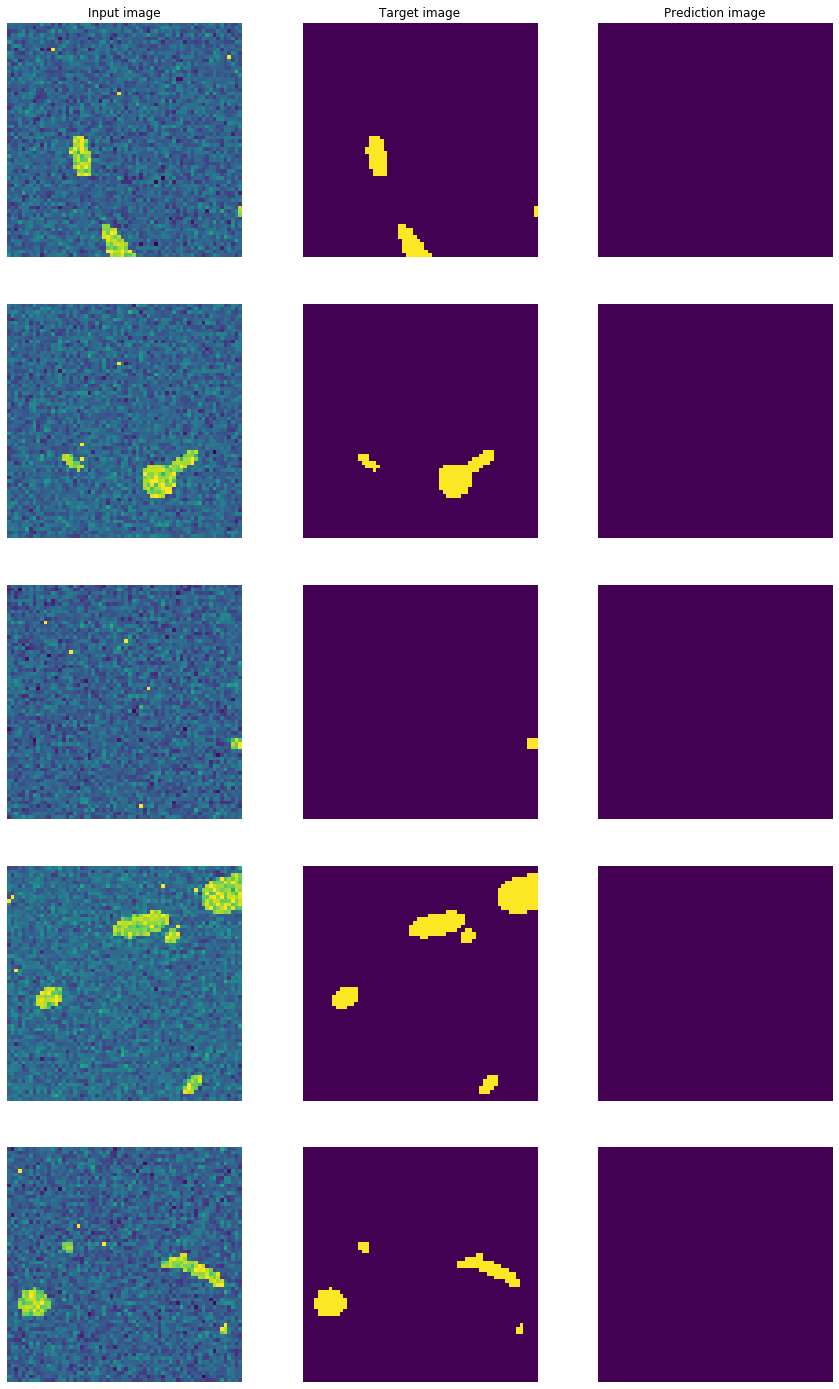

In [6]:
plt.figure(figsize=(15, 5 * 5))
for i, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.long)
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    print(preds.shape)
    print(pred.shape)

    inputs, targets, pred = inputs.numpy(), targets.numpy(), pred.numpy()

    # inputs
    plt.subplot(5, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(inputs[0,0,5])
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(5, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(targets[0,5])
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(5, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred[5])
    if i == 0:
        plt.title("Prediction image")